In [1]:
import flopy; import sys; import pathlib; import os; import time; import numpy as np; import matplotlib.pyplot as plt
import pandas as pd
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\50_MT3D_Wisconsin-Madison\09


In [2]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\50_MT3D_Wisconsin-Madison\\09')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'multiscale_heterogeneity_illustration'          ; workdir = os.path.join('.', directory_name)
if os.path.isdir(workdir) is False:
    os.mkdir(workdir) 
# datadir = os.path.join('..', directory_name, 'mt3d_test', 'mt3dms')   # see ?
folder_w_datafile = ('E:\\15_REPOS\\00_BETAMI\\bin\\Madison')
datafile_name1 = 'perm_2d_correlat_10_md_500_var_n0101.csv'       ; data_file_with_path1 = os.path.join(folder_w_datafile, datafile_name1)    
datafile_name2 = 'perm_2d_correlat_10_md_500_var_n0102.csv'       ; data_file_with_path2 = os.path.join(folder_w_datafile, datafile_name2)             
datafile_name3 = 'perm_2d_correlat_10_md_500_var_n0103.csv'       ; data_file_with_path3 = os.path.join(folder_w_datafile, datafile_name3)             

In [3]:
def model_2D(dirname, perlen_mt, hk, al, coarsen_factor):
    model_ws = os.path.join(workdir, dirname)                        ;  print(model_ws)

    itmuni   = 4                     ; mt_tunit = 'D'                ; lenuni = 2                    ; mt_lunit = 'M'   
    perlen_mf = [np.sum(perlen_mt)]  ; nper_mf  = len(perlen_mf)     ; nper   = len(perlen_mt)       ; nprs     = 100    ; hk_size  = hk.shape
    nlay      = hk_size[0]           ; nrow = hk_size[1]             ; ncol = hk_size[2]             ; # botm=-np.linspace(delv,delv*nlay,nlay)
    delv      = 0.25*coarsen_factor  ; delr = 0.25*coarsen_factor    ; delc = 1*coarsen_factor       #______________________ coarsen_factor
    laytyp = 0                       ; Lx = (ncol - 1) * delr        ; prsity = 0.3

    timprs = np.linspace(0, np.sum(perlen_mf), nprs, endpoint = False)
    ibound = np.ones((nlay, nrow, ncol) , dtype=int)                 ; ibound[0,:,0]= -1      ; ibound[0,:,-1] = -1 #(index)inlet|outlet
    strt   = np.zeros((nlay, nrow, ncol), dtype=float) ; h1 = 1.5    ; strt  [0,:,0]= h1      ; print("H diff across model: " + str(h1) + "m")
    icbund = np.ones((nlay, nrow, ncol) , dtype=int)
    sconc  = np.zeros((nlay, nrow, ncol), dtype=float)               ; C_in = [1.0, 0.0]      ; itype = -1

    cwell_info = np.zeros((nrow, 5), dtype=float)                    
    for row in range(0, nrow):
        cwell_info[row] = [0, row, 0, C_in[0], itype] 
    cwell_info2         = cwell_info.copy()   
    cwell_info2[:,3]    = C_in[1]                ; spd_mt = {0:cwell_info, 1:cwell_info2}                    ;  modelname_mf = dirname + '_mf'
    
    mf = flopy.modflow.Modflow     (modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis (mf, nlay=nlay, nrow=nrow, ncol=ncol, nper=nper_mf,delr=delr, delc=delc, top=0., botm=[0 - delv],
                                    perlen=perlen_mf, itmuni=itmuni, lenuni=lenuni)
    bas = flopy.modflow.ModflowBas (mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf (mf, hk=hk, laytyp=laytyp)
    pcg = flopy.modflow.ModflowPcg (mf)
    lmt = flopy.modflow.ModflowLmt (mf)
    oc = flopy.modflow.ModflowOc   (mf)  ; mf.write_input()      ; mf.run_model(silent=True)                  ; modelname_mt = dirname + '_mt'
    
    mt = flopy.mt3d.Mt3dms   (modelname=modelname_mt, model_ws=model_ws, exe_name=exe_name_mt, modflowmodel=mf)  
    btn = flopy.mt3d.Mt3dBtn (mt, icbund=icbund, prsity=prsity, sconc=sconc, tunit=mt_tunit, lunit=mt_lunit, nper=nper, 
                             perlen=perlen_mt, nprs=nprs, timprs=timprs)          ; mixelm = -1
    adv = flopy.mt3d.Mt3dAdv (mt, mixelm=mixelm)
    dsp = flopy.mt3d.Mt3dDsp (mt, al=al)
    ssm = flopy.mt3d.Mt3dSsm (mt, stress_period_data=spd_mt)
    gcg = flopy.mt3d.Mt3dGcg (mt)                                          ; mt.write_input()

    fname = os.path.join(model_ws, 'MT3D001.UCN')
    if os.path.isfile(fname):
        os.remove(fname)                                                  ; mt.run_model(silent=True)
    fname = os.path.join(model_ws, modelname_mf+'.hds')  ; hdobj = flopy.utils.HeadFile(fname)    ; heads = hdobj.get_data()
    fname = os.path.join(model_ws, 'MT3D001.UCN')        ; ucnobj = flopy.utils.UcnFile(fname)    ; times = np.array(ucnobj.get_times())
    conc = ucnobj.get_alldata()
   
    return mf, mt, times, conc, heads

In [4]:
kdata_m2 = np.loadtxt(data_file_with_path1, delimiter=',')                 # perm_2d_correlat_10_md_500_var_n0101.csv
nrow = int(kdata_m2[-2]) ;  ncol = int(kdata_m2[-1]) ; 
print('Number of rows in permeability map = ' + str(nrow))               ; print('Number of columns in permeability map = ' + str(ncol))
kdata_m2 = kdata_m2[0:-2] ;  rawk_m2 = kdata_m2.reshape(1, nrow, ncol)   ; real1_cmsec = rawk_m2*(1000*9.81*3600*24/8.9E-4)  # m/d

Number of rows in permeability map = 36
Number of columns in permeability map = 120


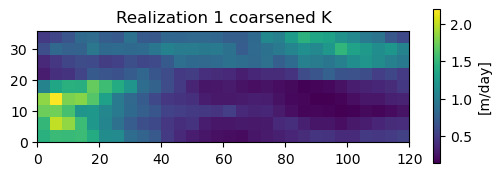

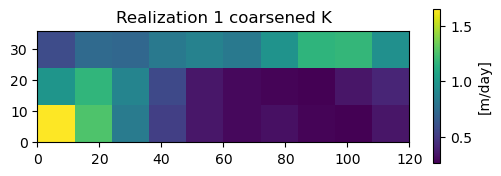

In [5]:
def plot_2d(map_data, dx, dy, colorbar_label, title, cmap):
    r, c = np.shape(map_data)                   ; x_coord = np.linspace(0, dx*c, c+1)   ; y_coord = np.linspace(0, dy*r, r+1)
    X, Y = np.meshgrid(x_coord, y_coord)        ; plt.figure(figsize=(6, 2), dpi=100) 
    plt.pcolormesh(X, Y, map_data, cmap=cmap, shading = 'auto') ; plt.gca().set_aspect('equal')  ; cbar = plt.colorbar() 
    cbar.set_label(colorbar_label) ; plt.tick_params(axis='both', which='major') ; plt.xlim((0, dx*c)) ; plt.ylim((0, dy*r)); plt.title(title)
    # plot_2d(real1_cmsec[0,:,:], 1, 1, '[m/day]', 'Realization 1 hydraulic conductivity', 'viridis')

def coarsen_geomean(array2d, coarseness):
    array_size = array2d.shape          ; rem0 = array_size[0] % coarseness    ; rem1 = array_size[1] % coarseness
    if rem0 + rem1 > 0:
        raise NameError('array is not divisible by coarseness factor')
    coarse_array = np.zeros([int(array_size[0]/coarseness), int(array_size[1]/coarseness)])
    n = coarseness**2  ; rind = 0
    for i in range(0, array_size[0], coarseness):
        cind = 0
        for j in range(0, array_size[1], coarseness):
            geo_mean_cell = np.exp(np.sum(np.log(array2d[ i:i + coarseness, j:j + coarseness] ))/n)
            coarse_array[rind, cind] = geo_mean_cell
            cind += 1
        rind +=1
    return coarse_array
    
geo_mean     = np.exp(np.sum(np.log(real1_cmsec))/real1_cmsec.size)*np.ones([1, nrow, ncol])
real1_4x     = coarsen_geomean(real1_cmsec[0,:,:], 4)
cnrow, cncol = real1_4x.shape
real1_4x_3d  = real1_4x.reshape(1, cnrow, cncol)  ; plot_2d(real1_4x_3d[0,:,:], 4, 4, '[m/day]', 'Realization 1 coarsened K', 'viridis')
real1_12x    = coarsen_geomean(real1_cmsec[0,:,:], 12)
cnrow, cncol = real1_12x.shape
real1_12x_3d = real1_12x.reshape(1, cnrow, cncol) ; plot_2d(real1_12x_3d[0,:,:],12,12,'[m/day]', 'Realization 1 coarsened K', 'viridis')

In [6]:
dirname = 'multiscale1'     ; perlen_mt = [7, 3*365]        ; al = 1
mf, mt, times, conc_hom     , heads       = model_2D(dirname, perlen_mt, geo_mean     , al, 1)
mf, mt, times1,    conc1    , heads1      = model_2D(dirname, perlen_mt, real1_cmsec  , al, 1)
mf, mt, times1c4,  conc_1c4 , heads_1c4   = model_2D(dirname, perlen_mt, real1_4x_3d  , al, 4)
mf, mt, times1c12, conc_1c12, heads_1c12  = model_2D(dirname, perlen_mt, real1_12x_3d , al, 12)

.\multiscale_heterogeneity_illustration\multiscale1
H diff across model: 1.5m
.\multiscale_heterogeneity_illustration\multiscale1
H diff across model: 1.5m
.\multiscale_heterogeneity_illustration\multiscale1
H diff across model: 1.5m
.\multiscale_heterogeneity_illustration\multiscale1
H diff across model: 1.5m


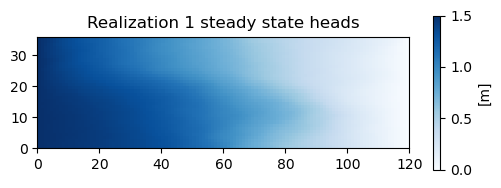

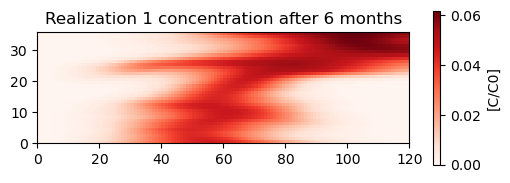

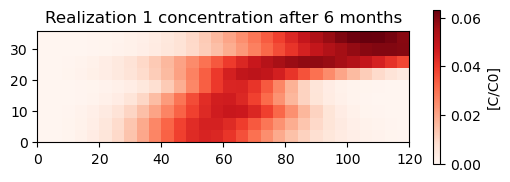

In [7]:
plot_2d(heads1[0,:,:], 1, 1,      '[m]',    'Realization 1 steady state heads', 'Blues')
plot_2d(conc1[16,0,:,:], 1, 1,    '[C/C0]', 'Realization 1 concentration after 6 months', 'Reds')
plot_2d(conc_1c4[16,0,:,:], 4, 4, '[C/C0]', 'Realization 1 concentration after 6 months', 'Reds')

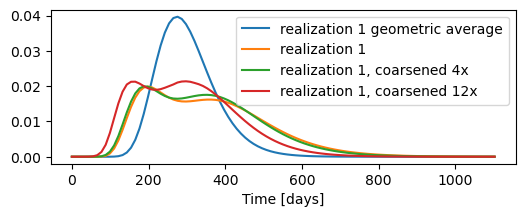

In [8]:
C_btc_r1_geomean = np.mean([conc_hom[:, 0, :, -1]], axis=2)
C_btc_r1 = np.mean([conc1[:, 0, :, -1]], axis=2)
C_btc_r1c4 = np.mean([conc_1c4[:, 0, :, -1]], axis=2)
C_btc_r1c12 = np.mean([conc_1c12[:, 0, :, -1]], axis=2)

plt.figure(figsize=(6, 2), dpi=100) ; plt.plot(times, np.transpose(C_btc_r1_geomean), label='realization 1 geometric average')
plt.plot(times, np.transpose(C_btc_r1), label='realization 1') ; plt.plot(times, np.transpose(C_btc_r1c4), label='realization 1, coarsened 4x')
plt.plot(times, np.transpose(C_btc_r1c12), label='realization 1, coarsened 12x') ; plt.xlabel('Time [days]'); plt.legend()

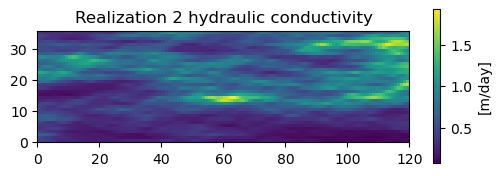

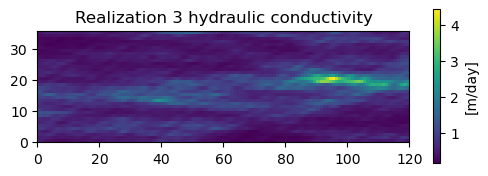

In [9]:
kdata_m2_2  = np.loadtxt(data_file_with_path2, delimiter=',')  ;  kdata_m2_3  = np.loadtxt(data_file_with_path3, delimiter=',')

kdata_m2_2  = kdata_m2_2[0:-2] ;    kdata_m2_2 = kdata_m2_2.reshape(1, nrow, ncol)
real2_cmsec = kdata_m2_2*(1000*9.81*3600*24/8.9E-4)
kdata_m2_3 = kdata_m2_3[0:-2]  ;   kdata_m2_3 = kdata_m2_3.reshape(1, nrow, ncol)
real3_cmsec = kdata_m2_3*(1000*9.81*3600*24/8.9E-4)

plot_2d(real2_cmsec[0,:,:], 1, 1, '[m/day]', 'Realization 2 hydraulic conductivity', 'viridis')
plot_2d(real3_cmsec[0,:,:], 1, 1, '[m/day]', 'Realization 3 hydraulic conductivity', 'viridis')

In [10]:
mf, mt, times2, conc2, heads2 = model_2D(dirname, perlen_mt, real2_cmsec, al, 1)
mf, mt, times3, conc3, heads3 = model_2D(dirname, perlen_mt, real3_cmsec, al, 1)

.\multiscale_heterogeneity_illustration\multiscale1
H diff across model: 1.5m
.\multiscale_heterogeneity_illustration\multiscale1
H diff across model: 1.5m


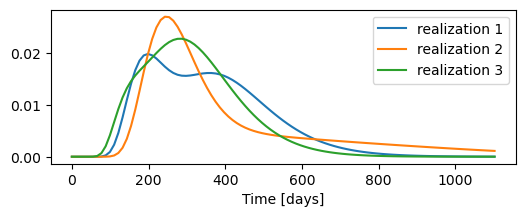

In [11]:
C_btc_r2 = np.mean([conc2[:, 0, :, -1]], axis=2)                #  uncoarsened
C_btc_r3 = np.mean([conc3[:, 0, :, -1]], axis=2)                ;  plt.figure(figsize=(6, 2), dpi=100)
plt.plot(times, np.transpose(C_btc_r1), label='realization 1')
plt.plot(times, np.transpose(C_btc_r2), label='realization 2')
plt.plot(times, np.transpose(C_btc_r3), label='realization 3')  ;  plt.xlabel('Time [days]')  ; plt.legend()

Bonus function to generate random fields using the [gstools python toolbox](https://github.com/GeoStat-Framework/GSTools).

In [12]:
# function to generate 3D random permeability fields 
def perm_field_generation(log_mD, log_var, correlat_len, ycorrelat_len, nlay, nrow, ncol, angle):
    x = np.arange(nlay)   ; y = np.arange(nrow)    ; z = np.arange(ncol)
    model = gs.Exponential(dim=3, var=10**log_var, len_scale=[1.0, ycorrelat_len, correlat_len], angles=[0.0, 0.0, angle])
    srf = gs.SRF(model)   #  srf = gs.SRF(model, seed=25300)
    field = 10**(srf.structured([x, y, z]) + log_mD)
    print('Geometric mean: ' + str(np.log10(np.max(field)/np.min(field))) + ' mD')
    field_km2 = field*(9.869233E-13/1000)    # convert from mD to km^2
    return field_km2